# Convolutional 100

In [1]:
# Import functions
from io_functions import *
from draw_functions import *

Using Theano backend.
Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


## Load the gammas and pi0s as nparrays of 20x20x25 event arrays

In [2]:
# Get the datasets for the first time
#signal = get_dataset('/data/vlimant/LCD/Gamma100GeV')
#bkg = get_dataset('/data/vlimant/LCD/Pi0100GeV')

# Save the datasets for faster future loading
#save_dataset("/data/vlimant/LCD/Gamma100GeV", signal)
#save_dataset("/data/vlimant/LCD/Pi0100GeV", bkg)

In [3]:
# Load the datasets
signal = load_dataset("/data/vlimant/LCD/Gamma100GeV")
bkg = load_dataset("/data/vlimant/LCD/Pi0100GeV")

## Prepare the data

In [4]:
# 1 is signal, 0 is background
X = np.concatenate( (signal, bkg), axis=0 )
Y = np.zeros( (len(X)) )
Y[:len(signal)] = 1
p = np.random.permutation(len(X))
X = X[p]
Y = Y[p]
X = X.reshape((X.shape[0], 1, 20, 20, 25))

train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.33, random_state=42)

## Create and train the model

In [9]:
# Convolutional Layers
model = Sequential()
model.add(Convolution3D(3, 4, 4, 5, input_shape = (1, 20, 20, 25), activation='relu'))
model.add(MaxPooling3D())
model.add(Flatten())

# Dense layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution3d_2 (Convolution3D)    (None, 3, 17, 17, 21243         convolution3d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling3d_2 (MaxPooling3D)      (None, 3, 8, 8, 10) 0           convolution3d_2[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)                (None, 1920)        0           maxpooling3d_2[0][0]             
____________________________________________________________________________________________________
dense_3 (Dense)                    (None, 100)         192100      flatten_2[0][0]                  
___________________________________________________________________________________________

In [ ]:
# Train the network
model.fit(train_data, train_labels, nb_epoch=100, batch_size=100, verbose=0)

### Classification Histogram

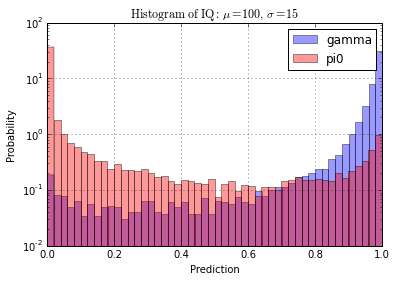

In [13]:
# Get the test signal and background to make the histogram
test_signal = test_data[np.where(test_labels==1)]
test_bkg    = test_data[np.where(test_labels==0)]

# Calculate the probabilities for the test sets
p_signal    = model.predict(test_signal)
p_bkg       = model.predict(test_bkg)

# Draw classification histogram
plt.hist(p_signal, 50, normed=1, facecolor='blue', alpha=0.4, label='gamma')
plt.hist(p_bkg , 50, normed=1, facecolor='red' , alpha=0.4, label='pi0')
plt.xlabel('Prediction')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### ROC Curve

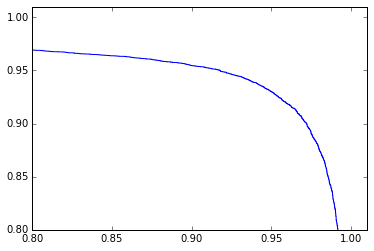

In [14]:
# Get classification predictions
predictions = model.predict(test_data)

# Draw the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, predictions)
plt.xlim([.8, 1.01])
plt.ylim([.8, 1.01])
plt.plot( tpr, 1-fpr )